<a href="https://colab.research.google.com/github/AfsanehHabibi/reddit-conversation-quality/blob/main/Conversation_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install anytree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 919.6 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = "/content/drive/MyDrive/University/RedditData/"

In [4]:
import pickle

with open(f"{base_path}conversations_with_features_dataframe.pkl", 'rb') as file:
    df = pickle.load(file)

In [10]:
df.head()

,id,conversation_id,reply_to,readability,evidence,has_reasoning,politensess,relatedness,subjectivity,polarity,new_readability,norm_readability,norm_politeness,mean_politeness_x,mean_politeness_y,mean_politeness
0,xyt38s,xyt38s,None,-0.5,0.5,0,0.095238,NaN,0.532381,0.224286,-0.5,0.95,0.117647,0.047619,0.047619,0.047619
1,iromk5a,xyt38s,xyt38s,-0.5,0.5,0,0.095238,0.887727,0.532381,0.224286,-0.5,0.95,0.117647,NaN,NaN,NaN
2,irpc624,xyt38s,xyt38s,-4.5,0.5,0,0.000000,0.031587,0.000000,0.000000,-4.5,0.55,0.000000,NaN,NaN,NaN
3,irp3pvs,xyt38s,xyt38s,-5.5,0.0,0,0.047619,0.000000,0.400000,0.800000,-5.5,0.45,0.058824,NaN,NaN,NaN
4,xyt38b,xyt38b,None,-2.5,0.5,1,0.380952,NaN,0.415179,0.015476,-2.5,0.75,0.470588,0.238095,0.238095,0.238095


In [ ]:
df

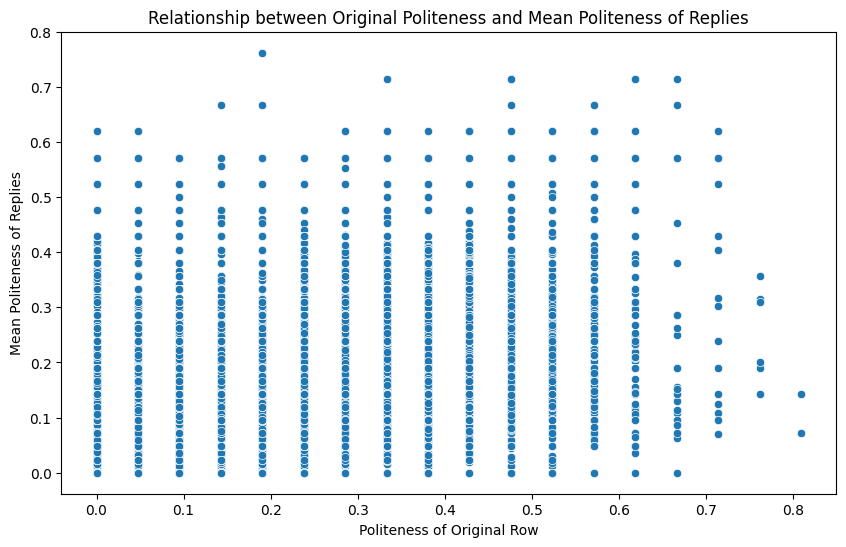

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame and 'id', 'reply_to', and 'politeness' are columns
# Create a new DataFrame with the mean politeness of replies for each original row
replies_df = df.loc[df['reply_to'].notnull()]
mean_politeness = replies_df.groupby('reply_to')['politensess'].mean()

# Merge the original rows with the mean politeness of replies
df = df.merge(mean_politeness.rename('mean_politeness'), left_on='id', right_index=True, how='left')

# Plot the relationship between the politeness of the original row and the mean politeness of replies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='politensess', y='mean_politeness', data=df)
plt.xlabel('Politeness of Original Row')
plt.ylabel('Mean Politeness of Replies')
plt.title('Relationship between Original Politeness and Mean Politeness of Replies')
plt.show()


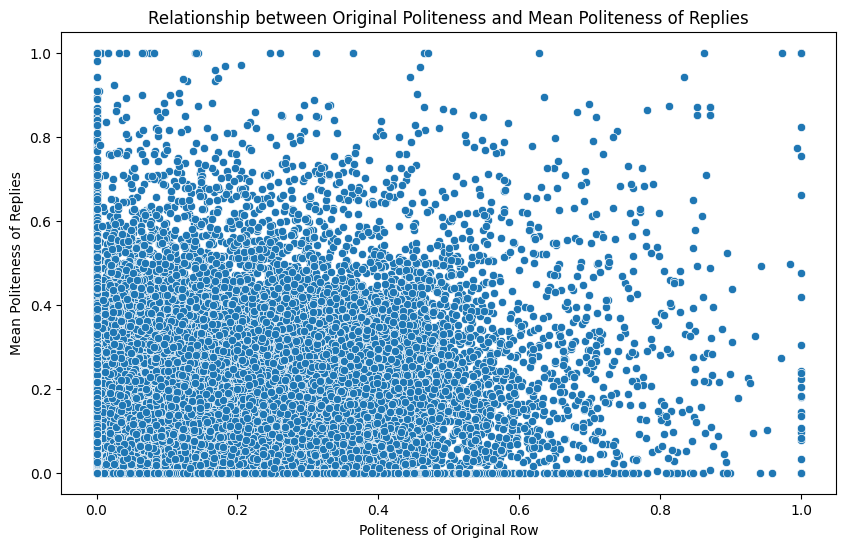

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame and 'id', 'reply_to', and 'politeness' are columns
# Create a new DataFrame with the mean politeness of replies for each original row
replies_df = df.loc[df['reply_to'].notnull()]
mean_politeness = replies_df.groupby('reply_to')['relatedness'].mean()

# Merge the original rows with the mean politeness of replies
df = df.merge(mean_politeness.rename('mean_relatedness'), left_on='id', right_index=True, how='left')

# Plot the relationship between the politeness of the original row and the mean politeness of replies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='relatedness', y='mean_relatedness', data=df)
plt.xlabel('Politeness of Original Row')
plt.ylabel('Mean Politeness of Replies')
plt.title('Relationship between Original Politeness and Mean Politeness of Replies')
plt.show()


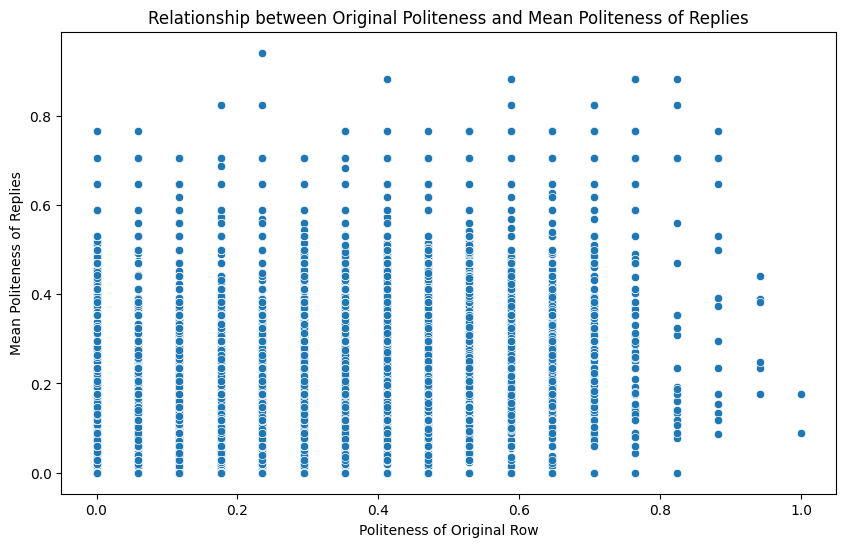

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume df is your DataFrame and 'id', 'reply_to', and 'politeness' are columns
# Create a new DataFrame with the mean politeness of replies for each original row
replies_df = df.loc[df['reply_to'].notnull()]
mean_politeness = replies_df.groupby('reply_to')['norm_politeness'].mean()

# Merge the original rows with the mean politeness of replies
df = df.merge(mean_politeness.rename('mean_norm_politeness'), left_on='id', right_index=True, how='left')

# Plot the relationship between the politeness of the original row and the mean politeness of replies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='norm_politeness', y='mean_norm_politeness', data=df)
plt.xlabel('Politeness of Original Row')
plt.ylabel('Mean Politeness of Replies')
plt.title('Relationship between Original Politeness and Mean Politeness of Replies')
plt.show()
